In [ ]:
!pip install mlflow dagshub --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not installed.
cudf 24.10.1 requires ptxcompiler, which is not installed.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml 24.10.0 requires nvidia-cublas, which is not installed.
cuml 24.10.0 requires nvidia-cufft, which is not installed.
cuml 24.10.0 requires nvidia-curand, which is not installed.
cuml 24.10.0 requires nvidia-cusolver, which is not installed.
cuml 24.10.0 requires nvidia-cusparse, which is not installed.
dask-cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
aiobotocore 2.15.2 requires botocore<1.35.37,>=1.35.16, but you h

In [ ]:
import dagshub
dagshub.init(repo_owner='youcefkrookss', repo_name='test', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=91e78c7c-7520-4fc9-8c12-7c44fde624d9&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=57e1f063ffdc76c73ca1452f383678b5ed55befba250aeddf7510ea72fdb03ed




Output()

Accessing as youcefkrookss

Initialized MLflow to track repo "youcefkrookss/test"

Repository youcefkrookss/test initialized!

In [ ]:
import mlflow

mlflow.set_tracking_uri('https://dagshub.com/youcefkrookss/test.mlflow')
mlflow.set_experiment(experiment_name="CNN_Cifar-100")

<Experiment: artifact_location='mlflow-artifacts:/e1f7e77d04264836b5f04fd768885739', creation_time=1733879078518, experiment_id='3', last_update_time=1733879078518, lifecycle_stage='active', name='CNN_Cifar-100', tags={}>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')


x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Afficher les dimensions de x_train, y_train, x_test et y_test
print(f"Dimensions de x_train : {x_train.shape}")
print(f"Dimensions de y_train : {y_train.shape}")
print(f"Dimensions de x_test : {x_test.shape}")
print(f"Dimensions de y_test : {y_test.shape}")

Dimensions de x_train : (50000, 32, 32, 3)
Dimensions de y_train : (50000, 1)
Dimensions de x_test : (10000, 32, 32, 3)
Dimensions de y_test : (10000, 1)


### Recherche d'hyperparamètres et validation croisée pour le CNN


1. **Augmentation des données :**
   - Les images du dataset sont augmentées à l'aide de transformations comme la rotation, le décalage, le cisaillement et la symétrie horizontale pour augmenter la diversité des données d'entraînement.

2. **Construction d'un modèle CNN paramétrable :**
   - Une fonction générique (`create_cnn_model`) permet de construire dynamiquement un CNN avec différents hyperparamètres, tels que le nombre de filtres dans les couches convolutionnelles, les taux de dropout, et le nombre de neurones dans les couches entièrement connectées.
     

3. **Recherche d'hyperparamètres :**
   - Utilisation de **Keras Tuner** pour effectuer une recherche en grille **(*grid search*)** des meilleurs hyperparamètres.

4. **Validation croisée K-Fold :**
   - Le dataset est divisé en 3 sous-ensembles (folds), et la validation croisée est utilisée pour évaluer la robustesse du modèle.

5. **Suivi et journalisation des expérimentations avec MLflow :**
   - Les hyperparamètres, les métriques (précision et perte), ainsi que les modèles entraînés sont enregistrés dans un serveur **MLflow**, permettant de suivre et comparer les résultats des différents folds.

6. **Analyse des résultats :**
   - Les précisions des 3 folds sont agrégées pour calculer une précision moyenne et son écart-type, fournissant une évaluation globale de la performance du modèle.

In [ ]:
import mlflow
import mlflow.keras
from sklearn.model_selection import KFold
import keras_tuner as kt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    shear_range=0.05
)

datagen.fit(x_train)

def create_cnn_model(hp):
    model = Sequential()

    # Première couche de convolution
    model.add(Conv2D(
        hp.Choice('filters_1', values=[32, 128]),
        (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]
    ))
    # Normalisation des lots
    model.add(BatchNormalization())

    # Deuxième couche de convolution
    model.add(Conv2D(
        hp.Choice('filters_2', values=[32, 128]),
        (3, 3), activation='relu', padding='same'
    ))
    # Normalisation des lots
    model.add(BatchNormalization())
    # Première couche de pooling
    model.add(MaxPooling2D((2, 2)))
    # Première couche de dropout
    model.add(Dropout(hp.Choice('dropout_1', values=[0.2, 0.3])))

    # Troisième couche de convolution
    model.add(Conv2D(
        hp.Choice('filters_3', values=[64, 192]),
        (3, 3), activation='relu', padding='same'
    ))
    # Normalisation des lots
    model.add(BatchNormalization())

    # Quatrième couche de convolution
    model.add(Conv2D(
        hp.Choice('filters_4', values=[64, 192]),
        (3, 3), activation='relu', padding='same'
    ))
    # Normalisation des lots
    model.add(BatchNormalization())
    # Deuxième couche de pooling
    model.add(MaxPooling2D((2, 2)))
    # Deuxième couche de dropout
    model.add(Dropout(hp.Choice('dropout_2', values=[0.2, 0.3])))

    # Cinquième couche de convolution
    model.add(Conv2D(
        hp.Choice('filters_5', values=[128, 256]),
        (3, 3), activation='relu', padding='same'
    ))

    # Normalisation des lots
    model.add(BatchNormalization())

    # Sixième couche de convolution
    model.add(Conv2D(
        hp.Choice('filters_6', values=[256, 384]),
        (3, 3), activation='relu', padding='same'
    ))
    # Normalisation des lots
    model.add(BatchNormalization())

    # Troisième couche de pooling
    model.add(MaxPooling2D((2, 2)))
    # Troisième couche de dropout
    model.add(Dropout(hp.Choice('dropout_3', values=[0.2, 0.3])))

    # Applatissement des caractéristiques pour les couches entièrement connectées
    model.add(Flatten())

    # Couche entièrement connectée
    model.add(Dense(
        hp.Choice('dense_units', values=[512, 1024]), activation='relu'
    ))
    # Normalisation des lots
    model.add(BatchNormalization())
    # Quatrième couche de dropout
    model.add(Dropout(hp.Choice('dropout_4', values=[0.3, 0.4])))

    # Couche de sortie avec 100 classes (pour CIFAR-100)
    model.add(Dense(100, activation='softmax'))

    # Compilation du modèle avec l'optimiseur Adam
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.0009472383604157623, 1e-4], default=0.0009472383604157623)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Validation croisée K-Fold avec 3 folds
kf = KFold(n_splits=3, shuffle=True, random_state=42)
# Liste pour enregistrer les précisions de validation pour chaque fold
fold_accuracies = []

# Callback EarlyStopping pour arrêter l'entraînement si la précision ne s'améliore pas
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

for fold, (train_index, val_index) in enumerate(kf.split(x_train)):
    print(f"Fold {fold + 1}/3")

    # Division des données en sous-ensembles pour l'entraînement et la validation
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Initialisation Keras Tuner pour la recherche d'hyperparamètres
    tuner = kt.GridSearch(
        create_cnn_model,
        objective='val_accuracy',  # Objectif : maximiser la précision sur l'ensemble de validation
        max_trials=20,
        directory=f'/kaggle/output/keras_tuner_dir_fold_{fold + 1}',
        project_name='cifar100_CNN_gridsearch'
    )

    # Recherche les meilleurs hyperparamètres pour ce fold
    tuner.search(
        x_train_fold,
        y_train_fold,
        epochs=10,
        validation_data=(x_val_fold, y_val_fold),
        batch_size=64,
        callbacks=[early_stop]
    )

     # Récupére les meilleurs hyperparamètres trouvés
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Meilleurs hyperparamètres pour le Fold {fold + 1} : {best_hps.values}")

    best_model = tuner.hypermodel.build(best_hps)

    # Enregistrement avec MLflow
    with mlflow.start_run(run_name=f"Fold_{fold + 1}"):
        mlflow.log_params(best_hps.values)  # Enregistrer les hyperparamètres

        history = best_model.fit(
            x_train_fold,
            y_train_fold,
            epochs=10,
            batch_size=64,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[early_stop]
        )

        for epoch, acc in enumerate(history.history['val_accuracy']):
            mlflow.log_metric("val_accuracy", acc, step=epoch)

        for epoch, loss in enumerate(history.history['val_loss']):
            mlflow.log_metric("val_loss", loss, step=epoch)

        mlflow.keras.log_model(best_model, "model")

    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Accuracy pour le Fold {fold + 1} : {fold_accuracy}")

# Résumé des performances des folds
with mlflow.start_run(run_name="Final_Summary"):
    mlflow.log_metric("mean_accuracy", np.mean(fold_accuracies))
    mlflow.log_metric("std_accuracy", np.std(fold_accuracies))

print(f"Accuracies des 3 folds : {fold_accuracies}")
print(f"Accuracy moyenne : {np.mean(fold_accuracies)}")
print(f"Écart-type des accuracies : {np.std(fold_accuracies)}")


Trial 20 Complete [00h 00m 56s]
val_accuracy: 0.2799712121486664

Best val_accuracy So Far: 0.46213847398757935
Total elapsed time: 00h 18m 12s
Meilleurs hyperparamètres pour le Fold 3 : {'filters_1': 32, 'filters_2': 32, 'dropout_1': 0.2, 'filters_3': 64, 'filters_4': 64, 'dropout_2': 0.2, 'filters_5': 128, 'filters_6': 384, 'dropout_3': 0.2, 'dense_units': 512, 'dropout_4': 0.3, 'learning_rate': 0.0009472383604157623}
Epoch 1/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.1082 - loss: 4.1238 - val_accuracy: 0.1964 - val_loss: 3.4414
Epoch 2/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2951 - loss: 2.8028 - val_accuracy: 0.3079 - val_loss: 2.9753
Epoch 3/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4026 - loss: 2.2653 - val_accuracy: 0.3708 - val_loss: 2.5793
Epoch 4/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4629 - loss: 1.9897 - val_accuracy: 0.4344 - val_loss: 2.1914
Epoch 5/10
521/521 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accu

2024/12/09 20:38:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/09 20:38:49 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5gzo7x23/model, flavor: keras). Fall back to return ['keras==3.3.3']. Set logging level to DEBUG to see the full traceback. 
2024/12/09 20:38:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Fold_3 at: http://34.201.243.188:5000/#/experiments/2/runs/9b524c7531eb43cdb713a9cb26882ffd
🧪 View experiment at: http://34.201.243.188:5000/#/experiments/2
Accuracy pour le Fold 3 : 0.4343573749065399
🏃 View run Final_Summary at: http://34.201.243.188:5000/#/experiments/2/runs/930545cb320a46a0bb4c7aa7accf7f82
🧪 View experiment at: http://34.201.243.188:5000/#/experiments/2
Accuracies des 3 folds : [0.5009899735450745, 0.45407092571258545, 0.4343573749065399]
Accuracy moyenne : 0.46313942472139996
Écart-type des accuracies : 0.027948214684014684


### Automate model training

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 384)      │       442,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 8, 8, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 4, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,146,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,784,580 (14.44 MB)

 Trainable params: 3,782,148 (14.43 MB)

 Non-trainable params: 2,432 (9.50 KB)

Dimensions de l'entraînement : (45000, 32, 32, 3)
Dimensions de la validation : (5000, 32, 32, 3)


2024/12/11 02:06:50 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 - 49s - 69ms/step - accuracy: 0.1544 - loss: 3.7381 - val_accuracy: 0.2502 - val_loss: 3.0761 - learning_rate: 9.4724e-04
Epoch 2/50
704/704 - 29s - 42ms/step - accuracy: 0.2900 - loss: 2.8573 - val_accuracy: 0.3236 - val_loss: 2.7459 - learning_rate: 9.4724e-04
Epoch 3/50
704/704 - 30s - 42ms/step - accuracy: 0.3627 - loss: 2.4714 - val_accuracy: 0.3408 - val_loss: 2.6482 - learning_rate: 9.4724e-04
Epoch 4/50
704/704 - 29s - 42ms/step - accuracy: 0.4096 - loss: 2.2393 - val_accuracy: 0.3862 - val_loss: 2.5863 - learning_rate: 9.4724e-04
Epoch 5/50
704/704 - 30s - 42ms/step - accuracy: 0.4464 - loss: 2.0822 - val_accuracy: 0.4624 - val_loss: 2.0596 - learning_rate: 9.4724e-04
Epoch 6/50
704/704 - 29s - 42ms/step - accuracy: 0.4789 - loss: 1.9267 - val_accuracy: 0.4986 - val_loss: 1.9078 - learning_rate: 9.4724e-04
Epoch 7/50
704/704 - 27s - 38ms/step - accuracy: 0.5056 - loss: 1.8047 - val_accuracy: 0.4886 - val_loss: 1.9592 - learning_rate: 9.4724e-04
Epoch 8/50
704/704 - 27s

2024/12/11 02:21:46 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2024/12/11 02:21:46 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2024/12/11 02:21:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpsgflv0c_/model, flavor: tensorflow). Fall back to return ['tensorflow==2.16.1', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/11 02:21:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       100
           1       0.88      0.67      0.76       100
           2       0.53      0.45      0.49       100
           3       0.58      0.34      0.43       100
           4       0.41      0.45      0.43       100
           5       0.69      0.74      0.71       100
           6       0.56      0.84      0.67       100
           7       0.56      0.61      0.59       100
           8       0.78      0.80      0.79       100
           9       0.85      0.70      0.77       100
          10       0.48      0.58      0.52       100
          11       0.52      0.45      0.48       100
          12       0.72      0.74      0.73       100
          13       0.60      0.63      0.61       100
          14       0.53      0.71      0.61       100
          15       0.64      0.63      0.63       100
          16       0.70      0.68      0

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
🏃 View run bouncy-donkey-763 at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/3/runs/d14a0ac356d94a76b3744954290d2e31
🧪 View experiment at: https://dagshub.com/youcefkrookss/test.mlflow/#/experiments/3


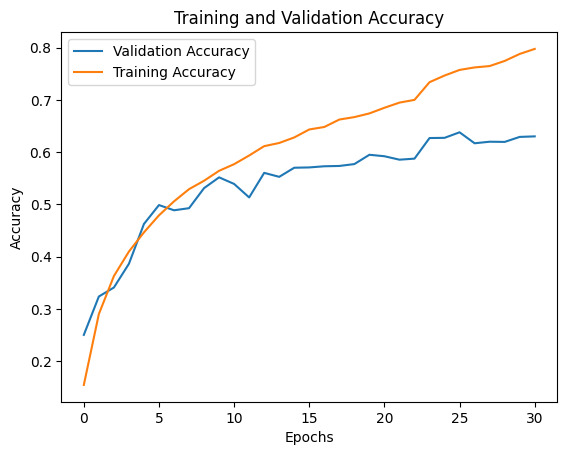

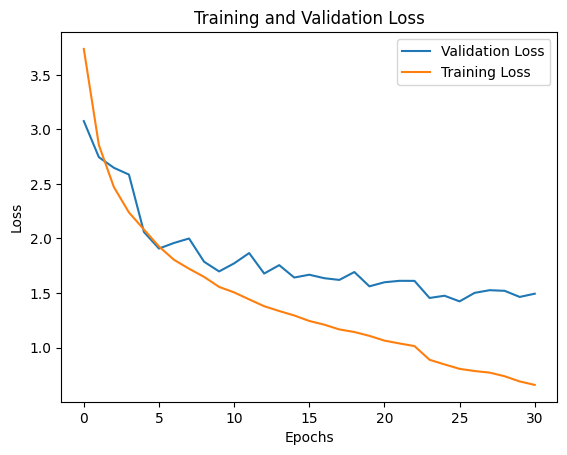

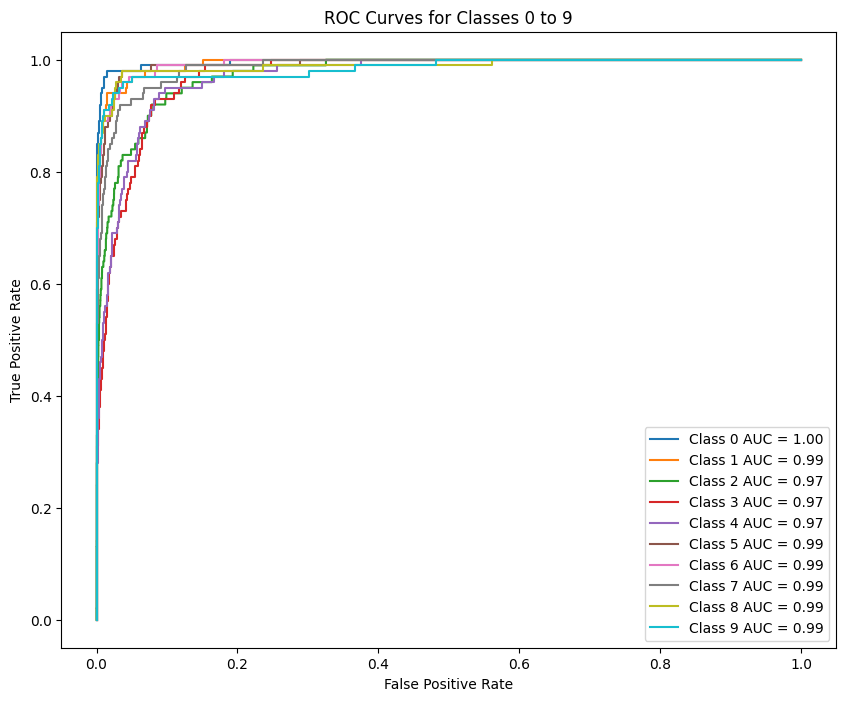

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import mlflow
import mlflow.tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# Activer l'autologging de MLflow pour TensorFlow
mlflow.tensorflow.autolog()

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

def create_final_cnn_model():
    model = Sequential()

    # Première couche de convolution
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))  # CIFAR-100 input shape
    model.add(BatchNormalization())

    # Deuxième couche de convolution
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Troisième couche de convolution
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    # Quatrième couche de convolution
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Cinquième couche de convolution
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    # Sixième couche de convolution
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Applatissement des caractéristiques pour les couches entièrement connectées
    model.add(Flatten())

    # Couche entièrement connectée
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Couche de sortie avec 100 classes (pour CIFAR-100)
    model.add(Dense(100, activation='softmax'))

    # Compilation du modèle avec l'optimiseur Adam
    model.compile(
        optimizer=Adam(learning_rate=0.0009472383604157623),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


final_model = create_final_cnn_model()
final_model.summary()

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# Callback pour réduire le taux d'apprentissage si la perte de validation ne diminue pas
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Callback pour arrêter l'entraînement si la précision de validation ne s'améliore pas
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

print(f"Dimensions de l'entraînement : {x_train.shape}")
print(f"Dimensions de la validation : {x_val.shape}")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    shear_range=0.05
)

datagen.fit(x_train)

# Utilisation de MLflow pour suivre l'entraînement
with mlflow.start_run():  # Démarrer une session de suivi MLflow
    history = final_model.fit(
        datagen.flow(x_train, y_train, batch_size=64),
        epochs=50,
        validation_data=(x_val, y_val),
        callbacks=[early_stop, lr_reduction],
        verbose=2
    )

    plt.figure()
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.savefig("accuracy_curve.png")
    mlflow.log_artifact("accuracy_curve.png")

    plt.figure()
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.savefig("loss_curve.png")
    mlflow.log_artifact("loss_curve.png")

    # Évaluation du modèle sur les données de test
    y_pred = final_model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = y_test.flatten()

    # Calcul des métriques : accuracy, precision, recall, AUC
    report = classification_report(y_test_classes, y_pred_classes, target_names=[str(i) for i in range(100)])
    print(report)

    # Binariser les labels pour calculer l'AUC
    y_test_binarized = label_binarize(y_test_classes, classes=range(100))
    auc = roc_auc_score(y_test_binarized, y_pred, average='macro', multi_class='ovr')
    print(f"AUC: {auc}")

    # Enregistrer les métriques dans MLflow
    accuracy = np.mean(y_test_classes == y_pred_classes)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_auc", auc)
    mlflow.log_text(report, "classification_report.txt")

    # Tracer les courbes AUC pour 10 classes dans un même graphe
    plt.figure(figsize=(10, 8))
    for i in range(10):
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc_score(y_test_binarized[:, i], y_pred[:, i]):.2f}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Classes 0 to 9")
    plt.legend(loc="lower right")
    plt.savefig("roc_curves_classes_0_to_9.png")
    mlflow.log_artifact("roc_curves_classes_0_to_9.png")

    # Enregistrer le modèle avec un exemple d'entrée et des dépendances explicites
    input_example = x_test[:1]
    mlflow.tensorflow.log_model(
        model=final_model,
        artifact_path="model",
        input_example=input_example,
        pip_requirements=["tensorflow==2.18.0", "cloudpickle==3.1.0"]
    )


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import mlflow
import mlflow.tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Load and eval Model

In [ ]:
import mlflow.tensorflow
import tensorflow as tf

# URI du modèle MLflow
logged_model = 'runs:/d14a0ac356d94a76b3744954290d2e31/model'

# Charger le modèle comme un modèle TensorFlow/Keras
loaded_model = mlflow.tensorflow.load_model(logged_model)

# Évaluation du modèle sur les données de test
loss, accuracy = loaded_model.evaluate(x_test, y_test, verbose=0)

# Afficher les résultats
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.4359
Test Accuracy: 0.6326


In [ ]:
! pip install shap lime

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### SHAP

  0%|          | 0/4998 [00:00<?, ?it/s]

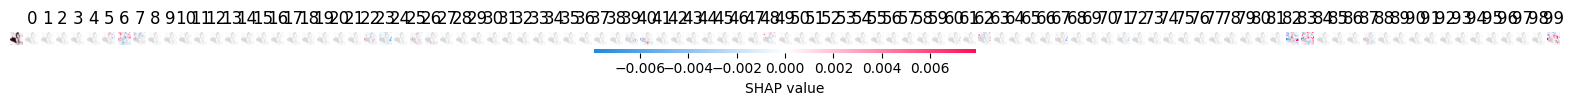

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Définir une fonction de prédiction
def f(x):
    return loaded_model(x)

# Créer un masker pour les images
masker = shap.maskers.Image("inpaint_telea", x_test[0].shape)

# Initialiser l'explainer SHAP
explainer = shap.Explainer(f, masker, output_names=list(range(100)))

# Sélectionner une seule image pour l'explication
ind = [600]  # Exemple : 600e image
image_to_explain = x_test[ind]  # Image au format (1, 32, 32, 3)

# Calculer les valeurs SHAP pour l'image
shap_values = explainer(image_to_explain, max_evals=5000, batch_size=50)

# Afficher les valeurs SHAP sous forme d'image
shap.image_plot(shap_values, image_to_explain)

  0%|          | 0/4998 [00:00<?, ?it/s]

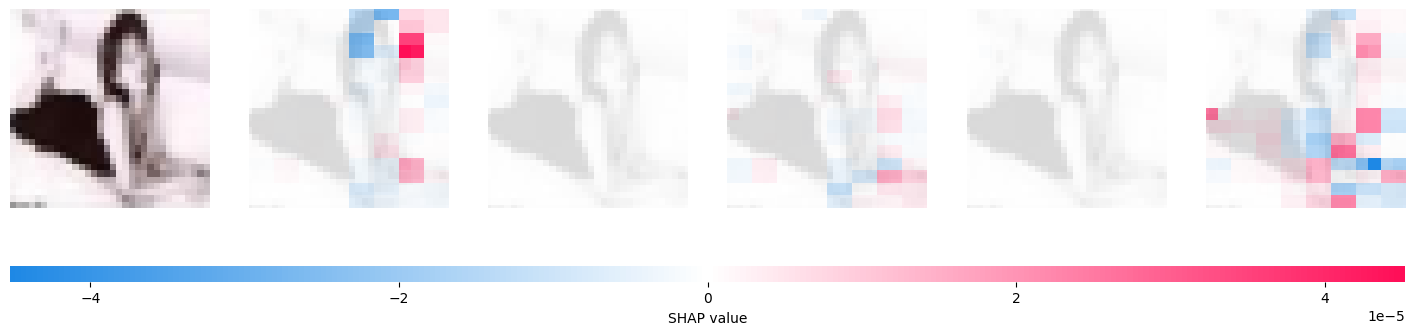

In [ ]:
# Définir une fonction de prédiction
def f(x):
    return loaded_model(x)

# Créer un masker pour les images
masker = shap.maskers.Image("inpaint_telea", x_test[0].shape)

# Initialiser l'explainer SHAP
explainer = shap.Explainer(f, masker, output_names=list(range(100)))

# Sélectionner une image à expliquer
ind = [600]  # Exemple : 600e image
image_to_explain = x_test[ind]

# Calculer les valeurs SHAP
shap_values = explainer(image_to_explain, max_evals=5000, batch_size=50)

# Obtenir les probabilités pour chaque classe
probs = loaded_model(image_to_explain)[0]

# Trier les indices des classes par probabilité décroissante
top_classes = np.argsort(probs)[-5:][::-1]  # Les 5 classes les plus probables

# Extraire les valeurs SHAP pour ces classes
filtered_shap_values = [shap_values.values[..., i] for i in top_classes]

# Afficher les explications pour les classes les plus probables
shap.image_plot(filtered_shap_values, image_to_explain)

  0%|          | 0/4998 [00:00<?, ?it/s]

Explaining image 600 (Top class: 98)


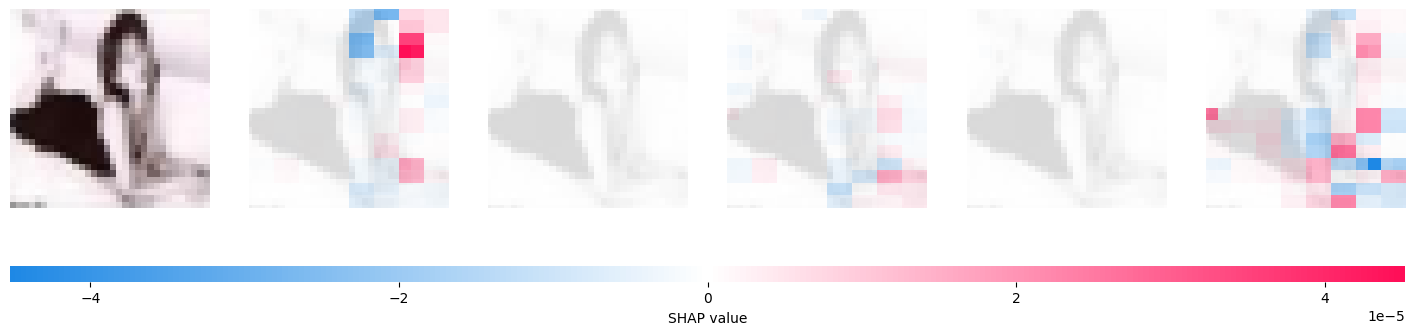

  0%|          | 0/4998 [00:00<?, ?it/s]

Explaining image 250 (Top class: 91)


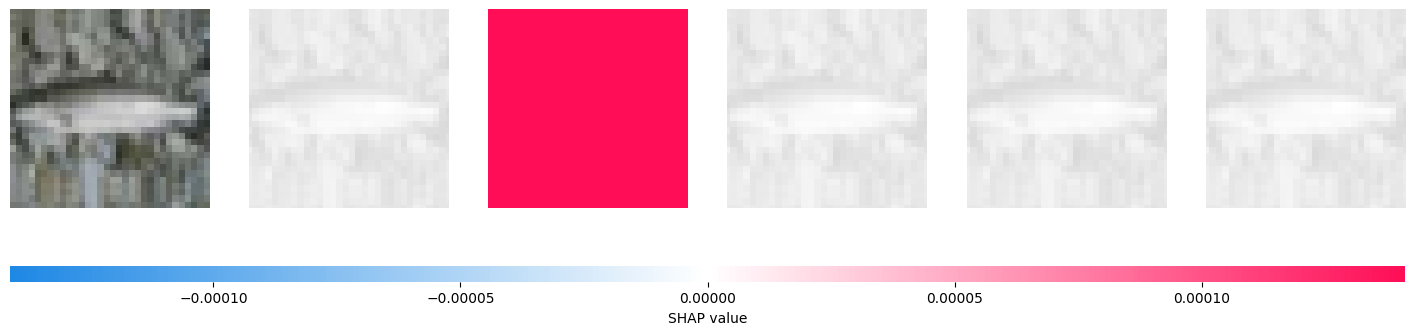

  0%|          | 0/4998 [00:00<?, ?it/s]

Explaining image 400 (Top class: 40)


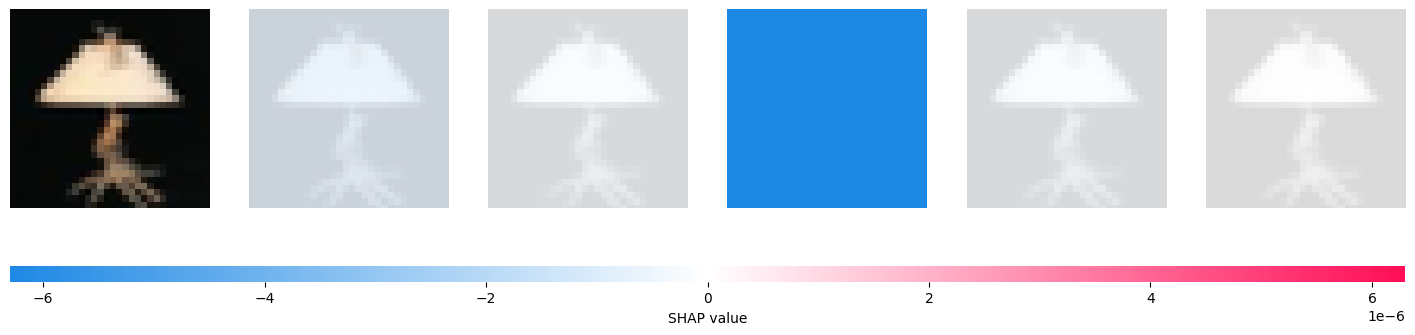

  0%|          | 0/4998 [00:00<?, ?it/s]

Explaining image 500 (Top class: 66)


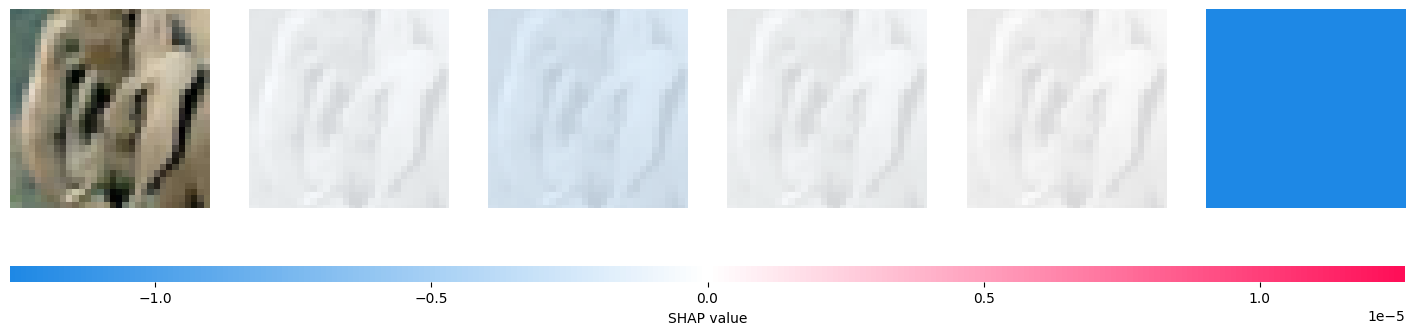

  0%|          | 0/4998 [00:00<?, ?it/s]

Explaining image 150 (Top class: 58)


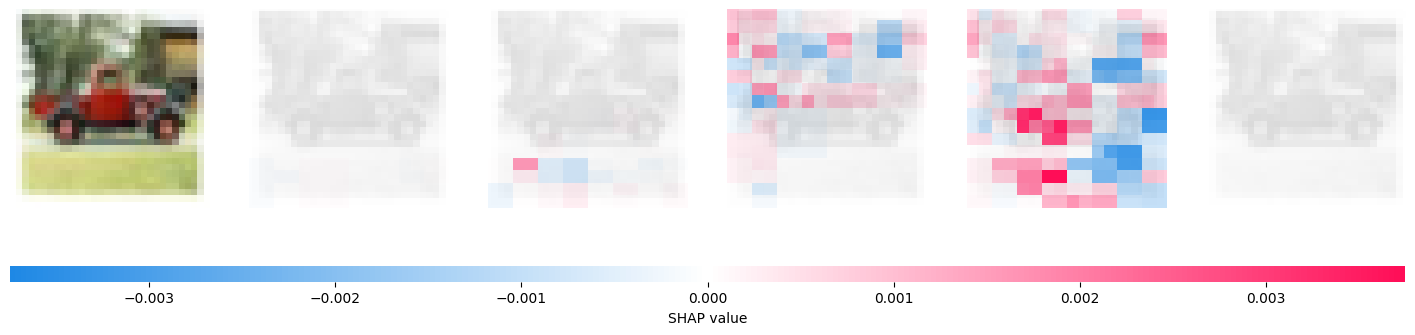

In [ ]:
# Définir une fonction de prédiction
def f(x):
    return loaded_model(x)

# Créer un masker pour les images
masker = shap.maskers.Image("inpaint_telea", x_test[0].shape)

# Initialiser l'explainer SHAP
explainer = shap.Explainer(f, masker, output_names=list(range(100)))

# Sélectionner 5 images à expliquer
image_indices = [600, 250, 400, 500, 150]  # Exemple : indices des 5 images

for idx in image_indices:
    # Extraire l'image
    image_to_explain = x_test[idx:idx+1]  # L'image doit être au format (1, 32, 32, 3)

    # Calculer les valeurs SHAP
    shap_values = explainer(image_to_explain, max_evals=5000, batch_size=50)

    # Obtenir les probabilités pour chaque classe
    probs = loaded_model(image_to_explain)[0]

    # Trier les indices des classes par probabilité décroissante
    top_classes = np.argsort(probs)[-5:][::-1]  # Les 5 classes les plus probables

    # Extraire les valeurs SHAP pour ces classes
    filtered_shap_values = [shap_values.values[..., i] for i in top_classes]

    # Afficher les explications pour les classes les plus probables
    print(f"Explaining image {idx} (Top class: {top_classes[0]})")
    shap.image_plot(filtered_shap_values, image_to_explain)


### Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

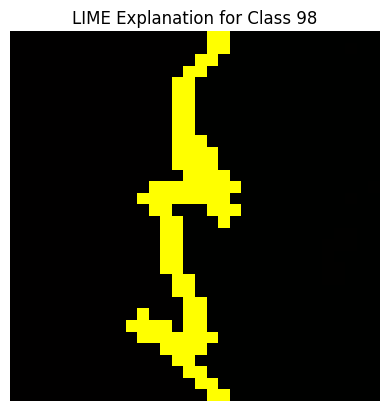

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Définir une fonction de prédiction adaptée à LIME
def predict(images):
    # LIME nécessite des prédictions sous forme de probabilité
    predictions = loaded_model(images)
    return predictions

# Initialiser LIME
explainer = lime_image.LimeImageExplainer()

# Sélectionner une image à expliquer
image_idx = 600  # Par exemple, la 600e image
image = x_test[image_idx]

# Générer une explication pour l'image
explanation = explainer.explain_instance(
    image,
    predict,  # La fonction de prédiction
    top_labels=5,  # Les 5 classes les plus probables
    hide_color=0,  # Couleur des zones masquées
    num_samples=1000  # Nombre d'échantillons générés pour l'explication
)

# Afficher l'explication pour la classe prédite
top_label = explanation.top_labels[0]  # Classe prédite la plus probable
temp, mask = explanation.get_image_and_mask(
    label=top_label,
    positive_only=False,  # Montrer les pixels positifs et négatifs
    num_features=10,  # Nombre de zones
    hide_rest=False  # Ne pas masquer le reste de l'image
)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation for Class {top_label}")
plt.axis('off')
plt.show()



  0%|          | 0/1000 [00:00<?, ?it/s]

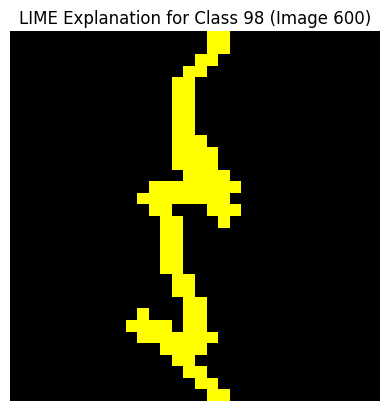

  0%|          | 0/1000 [00:00<?, ?it/s]

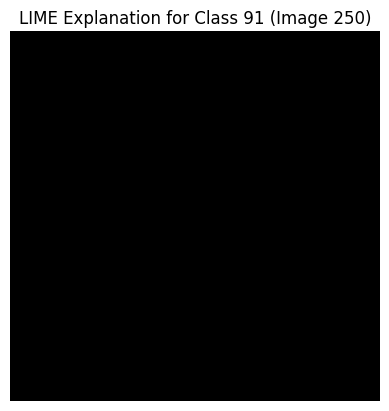

  0%|          | 0/1000 [00:00<?, ?it/s]

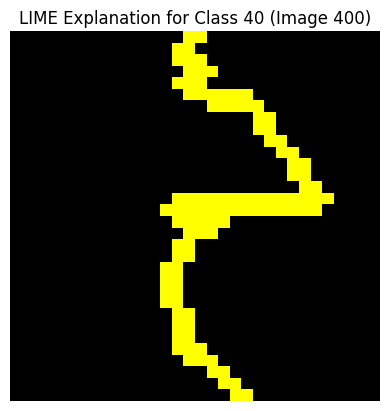

  0%|          | 0/1000 [00:00<?, ?it/s]

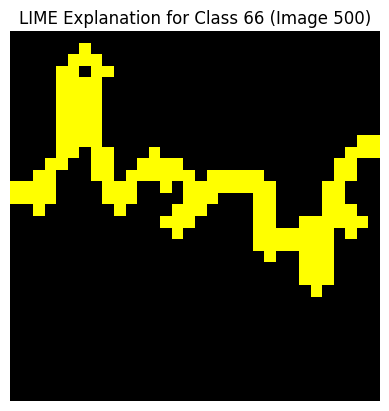

  0%|          | 0/1000 [00:00<?, ?it/s]

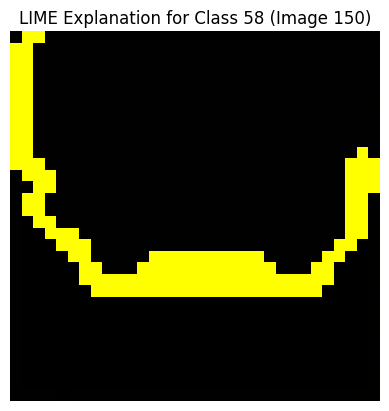

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Définir une fonction de prédiction adaptée à LIME
def predict(images):
    # LIME nécessite des prédictions sous forme de probabilité
    predictions = loaded_model(images)
    return predictions

# Initialiser LIME
explainer = lime_image.LimeImageExplainer()

# Sélectionner 5 images à expliquer
image_indices = [600, 250, 400, 500, 150]  # Exemple : indices des 5 images
for idx in image_indices:
    # Extraire l'image
    image = x_test[idx]

    # Générer une explication pour l'image
    explanation = explainer.explain_instance(
        image,
        predict,  # La fonction de prédiction
        top_labels=5,  # Les 5 classes les plus probables
        hide_color=0,  # Couleur des zones masquées
        num_samples=1000  # Nombre d'échantillons générés pour l'explication
    )

    # Afficher l'explication pour la classe prédite
    top_label = explanation.top_labels[0]  # Classe prédite la plus probable
    temp, mask = explanation.get_image_and_mask(
        label=top_label,
        positive_only=False,  # Montrer les pixels positifs et négatifs
        num_features=10,  # Nombre de zones
        hide_rest=False  # Ne pas masquer le reste de l'image
    )
    # Afficher l'image avec les explications
    plt.figure()
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title(f"LIME Explanation for Class {top_label} (Image {idx})")
    plt.axis('off')
    plt.show()

